# MVP: Machine Learning & Analytics — Previsão de Inadimplência em Cartão de Crédito

Autor: Guilherme Levcovitz

Matrícula: 4052025000762

Dataset : [UCI Default of Credit Card Clients](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)


## 1) Definição do problema

**Objetivo:** Prever se um cliente irá ou não entrar em inadimplência no próximo mês.

**Tipo de Problema:** Classificação.

**Premissas:** Dados de comportamento financeiro e características do cliente podem ajudar a prever inadimplência.

**Área de Aplicação:** Dados tabulares.

**Valor para o negócio:** Permite criar um score para concessão de crédito.

O conjunto de dados Default of Credit Card Clients reúne informações de clientes de cartão de crédito em Taiwan. O objetivo é prever se o cliente irá ou não deixar de pagar a fatura no próximo mês, sendo essa a variável alvo (target), codificada da seguinte forma:

1 = inadimplente / 0 = adimplente

Ao todo, o dataset contém 23 variáveis explicativas, distribuídas em quatro grupos principais:

- Informações Demográficas e de Crédito

X1 — Limite de crédito concedido (em NT dólar): inclui tanto o crédito individual quanto o crédito suplementar da família.

X2 — Gênero: 1 = masculino / 2 = feminino.

X3 — Escolaridade: 1 = pós-graduação; 2 = universidade; 3 = ensino médio; 4 = outros.

X4 — Estado civil: 1 = casado; 2 = solteiro; 3 = outros.

X5 — Idade (em anos).

- Histórico de Pagamentos

X6 – X11: situação do pagamento mensal de abril a setembro de 2005.

A escala de valores é:
-1 = pagamento em dia / 1 = atraso de 1 mês / 2 = atraso de 2 meses / …

- Valores das Faturas

X12 – X17: valor da fatura (em NT dólar) nos meses de abril a setembro de 2005.

- Valores dos Pagamentos Realizados

X18 – X23: valor do pagamento efetuado (em NT dólar) nos meses de abril a setembro de 2005.

## 2) Imports e carregamento dos dados

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve


In [4]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'

## 3) Preparação e limpeza dos dados

In [8]:
df = pd.read_excel(url, header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [12]:
print("\nFormato:", df.shape)
print("\nValores ausentes por coluna:")
print(df.isna().sum())
df.info()
df.describe()


Formato: (30000, 25)

Valores ausentes por coluna:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column               

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## 4) Análise exploratória

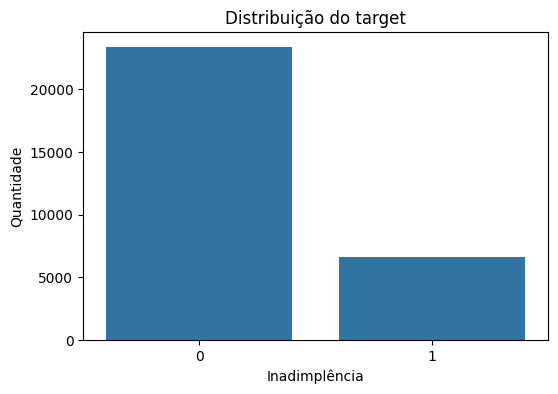

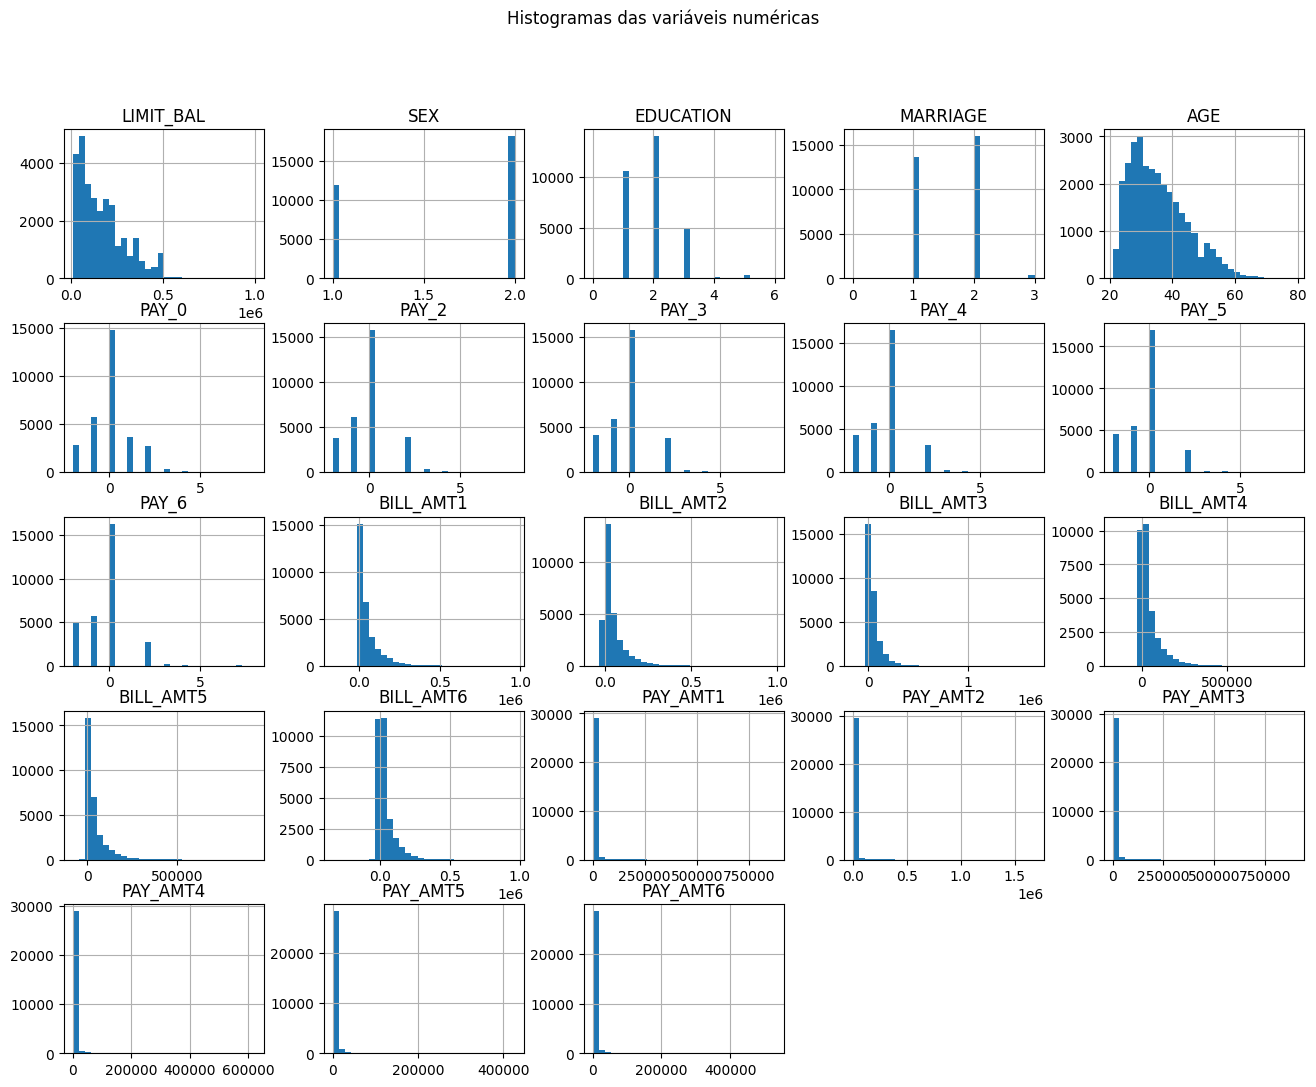

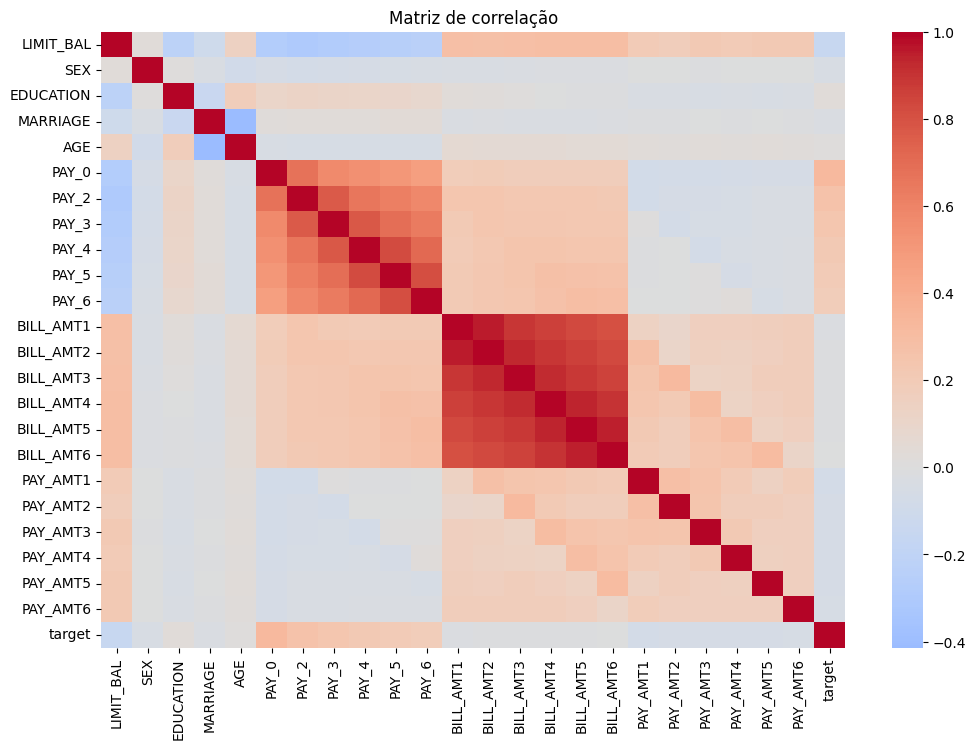

In [21]:


# Distribuição do target
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df)
plt.title("Distribuição do target")
plt.xlabel("Inadimplência")
plt.ylabel("Quantidade")
plt.show()

# Histogramas
df.drop(columns=['ID','target']).hist(figsize=(16,12), bins=30)
plt.suptitle("Histogramas das variáveis numéricas")
plt.show()

# Heatmap
plt.figure(figsize=(12,8))
corr = df.drop(columns=['ID']).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matriz de correlação")
plt.show()


## 5) Divisão entre treino e teste

In [14]:
RANDOM_STATE = 42
X = df.drop(columns=['target','ID'])
y = df['target']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.20, stratify=y_trainval, random_state=RANDOM_STATE)
print('train:', X_train.shape, 'val:', X_val.shape, 'test:', X_test.shape)


train: (19200, 23) val: (4800, 23) test: (6000, 23)


## 6) Pipeline


In [16]:
num_cols = X_train.columns.tolist()
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
preprocessor = ColumnTransformer([('num', num_transformer, num_cols)])


## 7) Aplicação dos modelos

In [17]:
models = {
    'logreg': Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))]),
    'rf': Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))]),
    'svc': Pipeline([('pre', preprocessor), ('clf', SVC(probability=True, random_state=RANDOM_STATE))])
}

results = {}
for name, model in models.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1]
    results[name] = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'roc_auc': roc_auc_score(y_val, y_proba),
        'train_time_s': t1 - t0
    }

pd.DataFrame(results).T


,accuracy,precision,recall,f1,roc_auc,train_time_s
logreg,0.811458,0.703896,0.255179,0.374568,0.722857,0.848022
rf,0.815417,0.644737,0.369115,0.469461,0.772750,11.082589
svc,0.817708,0.680851,0.331450,0.445852,0.714075,104.821150


## 8) Otimização de hiperparâmetros (Random Forest)

In [22]:
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

rf_pipeline = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(random_state=RANDOM_STATE))])
gs = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
gs.fit(X_trainval, y_trainval)
print('Melhores parâmetros:', gs.best_params_)


Best params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best CV ROC AUC: 0.7794434016776733


## 9) Avaliação de métricas

In [23]:
best_model = gs.best_estimator_
best_model.fit(X_trainval, y_trainval)
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:,1]

metrics = {
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred),
    'recall': recall_score(y_test, y_test_pred),
    'f1': f1_score(y_test, y_test_pred),
    'roc_auc': roc_auc_score(y_test, y_test_proba)
}
print('Test metrics:', metrics)


Test metrics: {'accuracy': 0.8158333333333333, 'precision': 0.6581196581196581, 'recall': 0.34815373021853807, 'f1': 0.4553967471660917, 'roc_auc': np.float64(0.7747983372549678)}


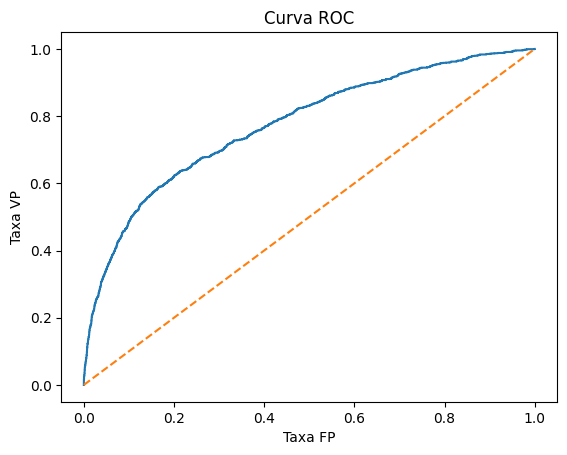

In [24]:
# Curva ROC

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('Taxa FP')
plt.ylabel('Taxa VP')
plt.title('Curva ROC')
plt.show()


## 10) Conclusão

- O modelo escolhido (Random Forest) alcançou um AUC de 0,77, indicando que ele discrimina bem clientes adimplentes de inadimplentes
- O dataset é desbalanceado, havendo mais clientes adimplentes do que inadimplentes
- Próximos passos:
  - Aplicar técnicas de balanceamento de classes
  - Explorar outros tipos de modelos (ex: XGBoost)
  - Analisar feature importance por meio de um gráfico Shap